# EDA

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.graphics.gofplots import qqplot

df = pd.read_csv('../src/kc_house_data.csv')

In [2]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
column_names = df.columns
column_names

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
#this takes a while to run, but it is a pairplot of correlations for all existing features

#sns.pairplot(data)

In [5]:
prices = df.price
prices.mean()

540296.5735055795

In [6]:
df.yr_built.describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

C:\Users\svett\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

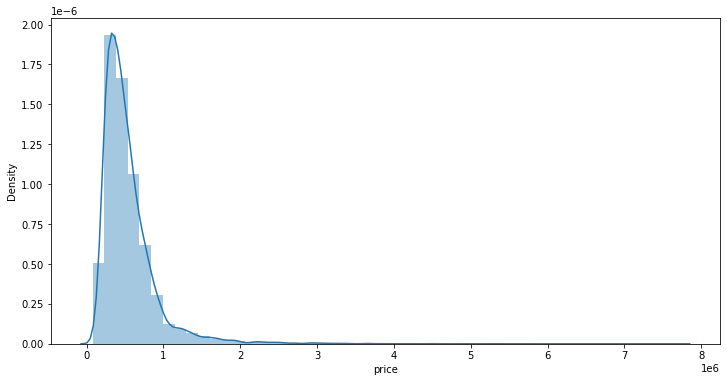

In [7]:
##distribution plot of home prices without scaling/standardization

fig, ax = plt.subplots(figsize = (12,6))

sns.distplot(prices)

In [8]:
#checking rooms data, seems like there is an outlier with 33 bedrooms - worth investigating further
df[['bedrooms', 'bathrooms']].describe()

,bedrooms,bathrooms
count,21597.000000,21597.000000
mean,3.373200,2.115826
std,0.926299,0.768984
min,1.000000,0.500000
25%,3.000000,1.750000
50%,3.000000,2.250000
75%,4.000000,2.500000
max,33.000000,8.000000


In [9]:
df[df['bedrooms'] == 33.00]

# upon looking up the parcel id, this seems to be an entry error - likely to be 3 bedrooms but we will drop this row from
# the model

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [10]:
# checking for NaN values - waterfront has a lot of missing data so unless we split this data into two models,
# it will probably be dropped
# yr_renovated and view will be dropped
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [11]:
##features to drop for inference: id, sqft_lot15, sqft_lot, view, lat, long
##rows to drop/separate: condition < 3, grade < 6

##additional features: price_per_sqft, location categorical, single-level categorical, 
##waterfront categorical, sale month categorical,

## potential splits - luxury homes - condition > 3 and grade 10-13 - likely to be able to include waterfront here
##                    non-luxury homes - condition > 3 and grade 6-9

In [12]:
df.sqft_basement.describe()

count     21597
unique      304
top         0.0
freq      12826
Name: sqft_basement, dtype: object

In [13]:
##replacing string '?' values with np.nan as float values

df['sqft_basement'] = df['sqft_basement'].replace("?", np.nan)
df['sqft_basement'] = df['sqft_basement'].astype('float64')

In [14]:
## most homes are in condition range 3-5
## because we are focusing on residential realty and not fixer-uppers, we will drop conditions 1 & 2

df.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [15]:
#investigaing zipcode column to see how many possible zipcodes and values exist by area

df['zipcode'].value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [16]:
#initial correlation matrix to look for multicollinearity

df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,-0.004548,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.325008,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.302683,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.282693,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.434576,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.015533,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,-0.245144,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,0.090200,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,0.276521,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,0.170972,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [17]:
# first model
# note that here, the predictor values do have a high correlation

formula1 = 'price ~ sqft_living + sqft_living15 + bathrooms + bedrooms'
first_model = ols(formula = formula1, data = df).fit()
first_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     5671.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:26:32   Log-Likelihood:            -2.9964e+05
No. Observations:               21597   AIC:                         5.993e+05
Df Residuals:                   21592   BIC:                         5.993e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.124e+04   7785.367      2.728      0.006    5981.914    3.65e+04
sqft_living     274.6320      3.849     71.355      0.000     267.088     282.176
sqft_living15    60.3673      3.909     15.445      0.000      52.706      68.028
bathrooms      7230.3124   3504.191      2.063      0.039     361.839    1.41e+04
bedrooms      -5.558e+04   2342.834    -23.725      0.000   -6.02e+04    -5.1e+04
==============================================================================
Omnibus:                    15088.233   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           601249.714
Skew:                           2.874   Prob(JB):                         0.00
Kurtosis:                      28.201   Cond. No.                     1.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

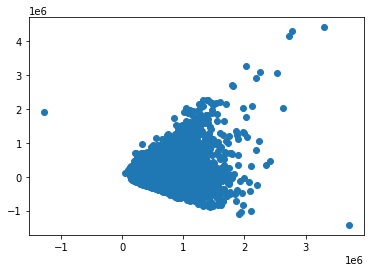

In [18]:
## checking residuals - they are not homoskedatic, so this is unlikely to be an accurate model

x = first_model.predict(df[['sqft_living','sqft_living15','bathrooms','bedrooms']])
y = first_model.resid
plt.scatter(x, y);

In [19]:
first_model.resid.max()
x.max()

df.loc[x[x == x.min()].index] ##the falsely-labeled home is one of the biggest outliers in this data set

#data.loc[y[y == y.max()].index]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


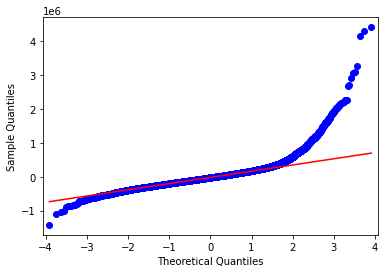

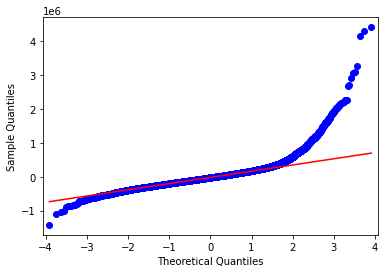

In [20]:
qqplot(first_model.resid, line = 'q')

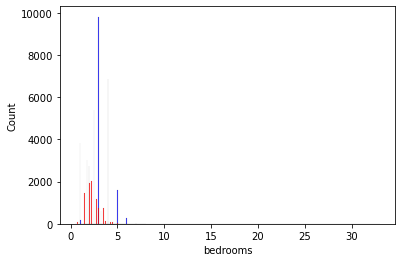

In [21]:
#looking at value distribution of bedrooms and bathrooms
sns.histplot(df['bedrooms'], color = 'b')

sns.histplot(df['bathrooms'], color = 'r');

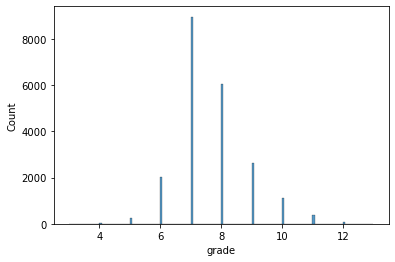

In [22]:
df.grade.value_counts().sort_values()

sns.histplot(df.grade);

##the home grades data seems to be mostly normally distributed with the bulk in 6-9

In [23]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [24]:
df['price_per_sqft'].describe()

count    21597.000000
mean       264.143368
std        110.000061
min         87.588235
25%        182.291667
50%        244.644550
75%        318.333333
max        810.138889
Name: price_per_sqft, dtype: float64

In [25]:
df['sqft_above'] = df['sqft_above'].astype('float64')

In [26]:
df['yard_size'] = df['sqft_lot']-df['sqft_above']-df['sqft_basement']

##this did not yield any particularly interesting results except that 767 of the listings have a negative yard size.
##investingating this using the assessor's website, it seems like those are multi-unit homes
##could be worth subsetting this as well

df.yard_size.value_counts()

 4780.0     20
 3420.0     20
 2910.0     20
 2570.0     19
 3120.0     19
            ..
 2924.0      1
-517.0       1
 7096.0      1
 38057.0     1
 2856.0      1
Name: yard_size, Length: 10578, dtype: int64

In [27]:
df[df['yard_size'] <= 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,yard_size
63,9528102996,12/7/2014,549000.0,3,1.75,1540,1044,3.0,0.0,0.0,...,0.0,2014,0.0,98115,47.6765,-122.320,1580,3090,356.493506,-496.0
116,3362400431,6/26/2014,518500.0,3,3.50,1590,1102,3.0,0.0,0.0,...,0.0,2010,0.0,98103,47.6824,-122.347,1620,3166,326.100629,-488.0
175,7234600798,2/10/2015,425000.0,3,2.50,1120,1100,2.0,0.0,0.0,...,300.0,2008,0.0,98122,47.6106,-122.310,1590,1795,379.464286,-20.0
406,7821200390,8/6/2014,450000.0,3,2.00,1290,1213,3.0,0.0,0.0,...,0.0,2001,0.0,98103,47.6609,-122.344,1290,3235,348.837209,-77.0
547,7899800860,3/19/2015,259950.0,2,2.00,1070,649,2.0,0.0,0.0,...,350.0,2008,0.0,98106,47.5213,-122.357,1070,928,242.943925,-421.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21579,1972201967,10/31/2014,520000.0,2,2.25,1530,981,3.0,0.0,0.0,...,50.0,2006,NaN,98103,47.6533,-122.346,1530,1282,339.869281,-549.0
21585,5100403806,4/7/2015,467000.0,3,2.50,1425,1179,3.0,0.0,0.0,...,0.0,2008,0.0,98125,47.6963,-122.318,1285,1253,327.719298,-246.0
21588,9834201367,1/26/2015,429000.0,3,2.00,1490,1126,3.0,0.0,0.0,...,0.0,2014,0.0,98144,47.5699,-122.288,1400,1230,287.919463,-364.0
21591,2997800021,2/19/2015,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,...,130.0,2008,0.0,98116,47.5773,-122.409,1330,1265,362.595420,-16.0


In [28]:
##using a zipcode map, I created a list of zipcodes that are outside of 'incorporated areas' - meaning these areas are
##outside of a municipality and do not have municipal services but also probably lower taxes
unincorporated_zipcodes = [98019, 98014, 98024, 98065, 98038, 98051, 98022, 98045, 98288, 98224,98051, 98029, 98014, 98077, 98053, 98010, 98070]

In [29]:
unincorporated_zipcodes = list(set(unincorporated_zipcodes))

In [30]:
## we wanted to explore whether the month of sale impacted the price, so we first created a month_sold feature
df['month_sold'] = df['date'].map(lambda x: x.split('/')[0]).astype('int64')

In [31]:
## created a season categorical

winter = [12,1,2]
fall = [9,10,11]
summer = [6,7,8]
spring = [3,4,5]
season_vals = []
for month in df['month_sold']:
    if month in winter:
        season_vals.append('winter')
    elif month in fall:
        season_vals.append('fall')
    elif month in summer:
        season_vals.append('summer')
    else:
        season_vals.append('spring')
df['season_sold'] = pd.DataFrame(season_vals)
df['season_sold'].value_counts()

spring    6518
summer    6328
fall      5056
winter    3695
Name: season_sold, dtype: int64

In [32]:
##created a binary variable for whether the property was in a municipal area or not - 1 means that it is not
df['unincorporated'] = np.where(df['zipcode'].isin(unincorporated_zipcodes), 1, 0)

In [33]:
## there are approximately 2800 homes outside of municipal areas, ranging from $80k to $2.3mil

df[df['unincorporated']  == 1].sort_values('price')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft,yard_size,month_sold,season_sold,unincorporated
465,8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,NaN,0.0,...,98014,47.6499,-121.909,1200,7500,186.046512,4620.0,5,spring,1
17183,5111400086,5/12/2014,110000.0,3,1.00,1250,53143,1.0,0.0,0.0,...,98038,47.4235,-122.051,1820,217800,88.000000,51893.0,5,spring,1
8073,1545807810,10/21/2014,118000.0,1,1.00,670,7957,1.0,0.0,0.0,...,98038,47.3594,-122.056,1600,7957,176.119403,7287.0,10,fall,1
5522,3821200050,6/4/2014,119500.0,3,1.00,1170,11000,1.0,0.0,0.0,...,98019,47.7346,-121.983,1590,10894,102.136752,9830.0,6,summer,1
3389,1917300025,1/27/2015,122000.0,2,1.00,860,6000,1.0,0.0,0.0,...,98022,47.2109,-121.985,1300,6000,141.860465,5140.0,1,winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11859,8835800350,1/12/2015,1950000.0,4,3.25,7420,167869,2.0,0.0,3.0,...,98045,47.4548,-121.764,5610,169549,262.803235,160449.0,1,winter,1
6685,2624089007,3/20/2015,2000000.0,2,2.50,3900,920423,2.0,0.0,0.0,...,98065,47.5371,-121.756,2720,411962,512.820513,916523.0,3,spring,1
8436,125069038,11/25/2014,2140000.0,4,3.75,5150,453895,2.0,NaN,3.0,...,98053,47.6795,-121.991,2500,215186,415.533981,448745.0,11,fall,1
11736,3629940160,3/11/2015,2200000.0,5,4.50,5840,17168,2.0,0.0,0.0,...,98029,47.5457,-121.991,4850,15017,376.712329,11328.0,3,spring,1


In [34]:
##checking home square footage by where in King county they are
neighbor_sqft_means = df.groupby('unincorporated')['sqft_living15'].mean()

##investigaing per square foot pricing based on location
location_per_sqft = df.groupby('unincorporated')['price_per_sqft'].mean()

##more granularity on pricing by specific zipcodes -- seems like some are vastly different from others, as expected
zipcode_per_sqft = df.groupby('zipcode')['price_per_sqft'].mean()

neighbor_sqft_means, location_per_sqft, zipcode_per_sqft

(unincorporated
 0    1953.680026
 1    2200.440860
 Name: sqft_living15, dtype: float64,
 unincorporated
 0    270.539063
 1    222.627922
 Name: price_per_sqft, dtype: float64,
 zipcode
 98001    151.347966
 98002    151.174091
 98003    157.113414
 98004    475.609615
 98005    314.966998
             ...    
 98177    292.982095
 98178    189.172528
 98188    169.007306
 98198    178.434333
 98199    376.659850
 Name: price_per_sqft, Length: 70, dtype: float64)

In [35]:
##here I wanted to look at distribution of square foot pricing by zipcodes 
## most are in the 200-300 per sqft range, with a few over 400
grouped_zips = df.groupby('zipcode')['price_per_sqft'].mean()
ranges = [0,100,200,300,400,500,600]

grouped_zips.groupby(pd.cut(grouped_zips.values, ranges)).count()

(0, 100]       0
(100, 200]    18
(200, 300]    32
(300, 400]    13
(400, 500]     6
(500, 600]     1
Name: price_per_sqft, dtype: int64

In [36]:
##defines a function that returns the value of the zipcode_per_sqft subset

def zipcode_price(zipcode):
    try:
        return zipcode_per_sqft.loc[zipcode]
    except:
        return np.nan  
    
##testing a value and checking to make sure it is an int or float type

zipcode_per_sqft.loc[98178], type(df['zipcode'][1])

(189.17252830749558, numpy.int64)

In [37]:
##created a new feature in the dataframe to apply a mean zipcode price to each row

df['zip_psqft'] = df['zipcode'].apply(zipcode_price)


##created a category variable for zipcode prices to be able to group properties
conditions = [(df['zip_psqft'] >= 100) & (df['zip_psqft'] < 200),
              (df['zip_psqft'] >= 200) & (df['zip_psqft'] < 300),
              (df['zip_psqft'] >= 300) & (df['zip_psqft'] < 400),
              (df['zip_psqft'] >= 400) & (df['zip_psqft'] < 500),
               df['zip_psqft'] >= 500]

choices = [1, 2, 3, 4, 5]


df['location_cost'] = np.select(conditions, choices, default = np.nan)

In [38]:
##created a list of zipcodes by price range
zips1 = set(list(df[df['location_cost'] == 1.0]['zipcode'].values))
zips2 = set(list(df[df['location_cost'] == 2.0]['zipcode'].values))
zips3 = set(list(df[df['location_cost'] == 3.0]['zipcode'].values))
zips4 = set(list(df[df['location_cost'] == 4.0]['zipcode'].values))
zips5 = set(list(df[df['location_cost'] == 5.0]['zipcode'].values))

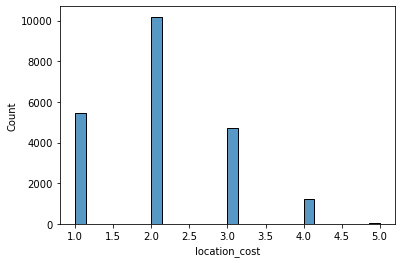

In [39]:
##investigating the distribution of zipcodes by price -- seems that most are under $400/sqft
## this distribution is slightly skewed and could be normalized

sns.histplot(df['location_cost']);

In [40]:
##created one more categorical feature for the decade of construction because categoricals for each year
## could substantially contribute to overfitting

conditions1 = [(df['yr_built'] >= 1900) & (df['yr_built'] < 1910),
               (df['yr_built'] >= 1910) & (df['yr_built'] < 1920),
               (df['yr_built'] >= 1920) & (df['yr_built'] < 1930),
               (df['yr_built'] >= 1930) & (df['yr_built'] < 1940),
               (df['yr_built'] >= 1940) & (df['yr_built'] < 1950),
               (df['yr_built'] >= 1950) & (df['yr_built'] < 1960),
               (df['yr_built'] >= 1960) & (df['yr_built'] < 1970),
               (df['yr_built'] >= 1970) & (df['yr_built'] < 1980),
               (df['yr_built'] >= 1980) & (df['yr_built'] < 1990),
               (df['yr_built'] >= 1990) & (df['yr_built'] < 2000),
               (df['yr_built'] >= 2000) & (df['yr_built'] < 2010),
               (df['yr_built'] >= 2010) & (df['yr_built'] < 2020)]

choices1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

df['decade_built'] = np.select(conditions1, choices1, np.nan)

# Final dataframe before selecting features for OLS modeling

In [41]:
## this dataframe contains homes that are 3 or above, condition-wise
## because we are focusing on livable homes, not fixer-uppers

data = df[df['condition'] >= 3]


## there are still NaN values in this dataframe, but they will be addressed on a subsetting basis
data.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2354
view                63
condition            0
grade                0
sqft_above           0
sqft_basement      449
yr_built             0
yr_renovated      3810
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price_per_sqft       0
yard_size          449
month_sold           0
season_sold          0
unincorporated       0
zip_psqft            0
location_cost        0
decade_built         0
dtype: int64

In [42]:
##subsetting the main dataframe with houses with price per square foot within 3 standard deviations of the mean
## potentially useful for future models
df[~(np.abs(stats.zscore(df['price_per_sqft'])) > 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,price_per_sqft,yard_size,month_sold,season_sold,unincorporated,zip_psqft,location_cost,decade_built
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1340,5650,188.050847,4470.0,10,fall,0,189.172528,1.0,5.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1690,7639,209.338521,4672.0,12,winter,0,282.680191,2.0,5.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,2720,8062,233.766234,9230.0,2,winter,0,225.145368,2.0,3.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1360,5000,308.163265,3040.0,12,winter,0,337.245108,3.0,6.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1800,7503,303.571429,6400.0,2,winter,0,265.686627,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,1530,1509,235.294118,-399.0,5,spring,0,369.882756,3.0,10.0
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,1830,7200,173.160173,3503.0,2,winter,0,225.496990,2.0,11.0
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,1020,2007,394.216667,330.0,6,summer,0,312.285969,3.0,10.0
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,1410,1287,250.000000,788.0,1,winter,0,251.586071,2.0,10.0


## Subsetting for Luxury Homes Model

In [43]:
luxury_df = data[data['grade'] >= 10]

luxury_df.info(), luxury_df.isna().sum()
## as you can see here, there are considerably fewer null values in the 'waterfront' feature for luxury homes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633 entries, 5 to 21584
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1633 non-null   int64  
 1   date            1633 non-null   object 
 2   price           1633 non-null   float64
 3   bedrooms        1633 non-null   int64  
 4   bathrooms       1633 non-null   float64
 5   sqft_living     1633 non-null   int64  
 6   sqft_lot        1633 non-null   int64  
 7   floors          1633 non-null   float64
 8   waterfront      1468 non-null   float64
 9   view            1626 non-null   float64
 10  condition       1633 non-null   int64  
 11  grade           1633 non-null   int64  
 12  sqft_above      1633 non-null   float64
 13  sqft_basement   1603 non-null   float64
 14  yr_built        1633 non-null   int64  
 15  yr_renovated    1340 non-null   float64
 16  zipcode         1633 non-null   int64  
 17  lat             1633 non-null   

(None,
 id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront        165
 view                7
 condition           0
 grade               0
 sqft_above          0
 sqft_basement      30
 yr_built            0
 yr_renovated      293
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 price_per_sqft      0
 yard_size          30
 month_sold          0
 season_sold         0
 unincorporated      0
 zip_psqft           0
 location_cost       0
 decade_built        0
 dtype: int64)

## Luxury Home OLS models using different combinations of features

In [44]:
## feature pruning for an inferential model 
## five current potential features have NaN values. View, basement sqft, and year renovated will be dropped.
## NaN values for waterfront and yard size will be dropped because there is not an accurate way to predict this data
to_drop_cols = ['id', 'date', 'view', 'yr_renovated', 'zipcode', 'lat', 'long', 'price_per_sqft', 'month_sold', 'zip_psqft', 'sqft_above', 'yr_built']
lux_ols_base = luxury_df.drop(columns = to_drop_cols, axis =1)

lux_ols_base.dropna(inplace = True) ##reduced the data to 1440 rows from 1633
lux_ols_base.corr() ##correlation matrix to explore multicollinearity issues

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_basement,sqft_living15,sqft_lot15,yard_size,unincorporated,location_cost,decade_built
price,1.000000,0.267294,0.501287,0.625615,-0.028541,0.018779,0.394747,0.211492,0.499917,0.408202,0.198159,-0.027110,-0.038077,-0.176257,0.563892,-0.240730
bedrooms,0.267294,1.000000,0.472689,0.483588,-0.038383,0.095931,-0.061881,0.065429,0.189528,0.257880,0.208849,-0.032895,-0.045789,-0.054100,0.149532,-0.063516
bathrooms,0.501287,0.472689,1.000000,0.712079,0.081714,0.133423,0.059647,-0.018839,0.425515,0.386719,0.212953,0.083672,0.071109,-0.014451,0.172180,0.092858
sqft_living,0.625615,0.483588,0.712079,1.000000,0.151291,0.088193,0.123476,0.042409,0.580058,0.499382,0.408697,0.156070,0.136478,0.034094,0.120540,-0.006316
sqft_lot,-0.028541,-0.038383,0.081714,0.151291,1.000000,-0.054162,-0.029361,-0.037354,0.076814,-0.018137,-0.045521,0.714083,0.999888,0.348654,-0.179834,0.067447
floors,0.018779,0.095931,0.133423,0.088193,-0.054162,1.000000,-0.016220,-0.102132,0.067201,-0.281367,-0.081233,-0.052571,-0.055615,0.011906,0.043443,0.089354
waterfront,0.394747,-0.061881,0.059647,0.123476,-0.029361,-0.016220,1.000000,0.086140,0.098553,0.166477,0.017212,-0.018920,-0.031294,-0.084731,0.027241,-0.088460
condition,0.211492,0.065429,-0.018839,0.042409,-0.037354,-0.102132,0.086140,1.000000,-0.026382,0.177630,0.062339,-0.026533,-0.038077,-0.091144,0.198005,-0.503364
grade,0.499917,0.189528,0.425515,0.580058,0.076814,0.067201,0.098553,-0.026382,1.000000,0.194820,0.365250,0.086984,0.068197,-0.013683,0.110304,0.021421
sqft_basement,0.408202,0.257880,0.386719,0.499382,-0.018137,-0.281367,0.166477,0.177630,0.194820,1.000000,0.107424,-0.008084,-0.025738,-0.137139,0.235035,-0.206730


In [45]:
##the home's grade strongly correlates with square footage 
##sqft_living correlates strongly with number of bathrooms and somewhat strongly with bedrooms
##sqft_living correlates strongly with basement sqft
##sqft_lot and sqft_lot15 strongly correlate and so does yard size but that is an engineered feature

In [46]:
lux_ols_base.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'yard_size', 'season_sold', 'unincorporated',
       'location_cost', 'decade_built'],
      dtype='object')

In [47]:
##Initialized dummy variables for all categorical features
dummy_list = ['unincorporated','waterfront','bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'season_sold', 'location_cost', 'decade_built']


inc_dummies = pd.get_dummies(lux_ols_base['unincorporated'].astype(int), prefix='city', drop_first=True)
water_dummies = pd.get_dummies(lux_ols_base['waterfront'].astype(int), prefix='water', drop_first=True)
bed_dummies = pd.get_dummies(lux_ols_base['bedrooms'].astype(int), prefix='bed', drop_first=True)
bath_dummies = pd.get_dummies(lux_ols_base['bathrooms'].astype(int), prefix = 'bath', drop_first = True)
floor_dummies = pd.get_dummies(lux_ols_base['floors'].astype(int), prefix='floor', drop_first=True)
cond_dummies = pd.get_dummies(lux_ols_base['condition'].astype(int), prefix='cond', drop_first=True)
grade_dummies = pd.get_dummies(lux_ols_base['grade'].astype(int), prefix='grade', drop_first=True)
season_dummies = pd.get_dummies(lux_ols_base['season_sold'], prefix='month', drop_first=True)
loc_dummies = pd.get_dummies(lux_ols_base['location_cost'].astype(int), prefix='loc', drop_first=True)
built_dummies = pd.get_dummies(lux_ols_base['decade_built'].astype(int), prefix='built', drop_first=True)

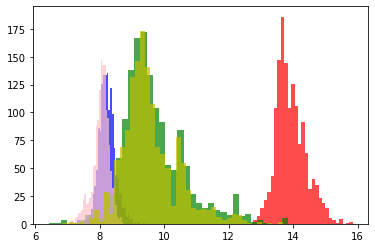

In [48]:
##Initialized log-transformed variables for all continuous variables without negative values

log_price = np.log(lux_ols_base['price'])
log_sqft_living = np.log(lux_ols_base['sqft_living'])
log_sqft_lot = np.log(lux_ols_base['sqft_lot'])
log_sqft_living15 = np.log(lux_ols_base['sqft_living15'])
log_sqft_lot15 = np.log(lux_ols_base['sqft_lot15'])

plt.hist(log_price, bins = 'auto', color = 'r', alpha = .7);
plt.hist(log_sqft_living, bins = 'auto', color = 'b', alpha = .7);
plt.hist(log_sqft_lot, bins = 'auto', color = 'g', alpha = .7);
plt.hist(log_sqft_living15, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(log_sqft_lot15, bins = 'auto', color = 'y', alpha = .7);

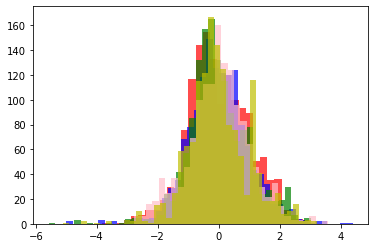

In [49]:
##Performed a Power Transformation on all continuous variable with no negative values

power = PowerTransformer()

power_price = power.fit_transform(np.array(log_price).reshape(-1, 1))
power_sqft_living = power.fit_transform(np.array(log_sqft_living).reshape(-1, 1))
power_sqft_lot = power.fit_transform(np.array(log_sqft_lot).reshape(-1, 1))
power_sqft_living15 = power.fit_transform(np.array(log_sqft_living15).reshape(-1, 1))
power_sqft_lot15 = power.fit_transform(np.array(log_sqft_lot15).reshape(-1, 1))

plt.hist(power_price, bins = 'auto', color = 'r', alpha = .7);
plt.hist(power_sqft_living, bins = 'auto', color = 'b', alpha = .7);
plt.hist(power_sqft_lot, bins = 'auto', color = 'g', alpha = .7);
plt.hist(power_sqft_living15, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(power_sqft_lot15, bins = 'auto', color = 'y', alpha = .7);

## Luxury Model 1

In [50]:
lux_ols1 = lux_ols_base.drop(columns = ['sqft_living', 'sqft_lot'], axis = 1) ##dropping multicollinear continuous vars

##Addressing categorical features
lux_ols1 = lux_ols1.drop(columns = dummy_list, axis = 1) ##dropping original categoricals
lux_ols1 = pd.concat([lux_ols1, inc_dummies, water_dummies, bed_dummies, bath_dummies, floor_dummies, cond_dummies, grade_dummies, season_dummies, loc_dummies, built_dummies], axis = 1)


##Scaling all features
ss = StandardScaler()

scaled_lux_ols1 = pd.DataFrame(ss.fit_transform(lux_ols1))
scaled_lux_ols1.columns = lux_ols1.columns

scaled_lux_ols1

,price,sqft_basement,sqft_living15,sqft_lot15,yard_size,city_1,water_1,bed_2,bed_3,bed_4,...,built_2,built_3,built_4,built_5,built_6,built_7,built_8,built_9,built_10,built_11
0,-0.050082,1.553755,1.993683,1.577095,0.934600,2.374014,-0.201153,-0.121652,-0.532374,0.893170,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,-0.622321,1.51499,-0.30288
1,-0.311983,1.803316,0.407060,0.298556,0.233362,-0.421227,-0.201153,-0.121652,-0.532374,-1.119608,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,4.207291,-0.443855,-0.622321,-0.66007,-0.30288
2,-0.598007,0.834429,0.032979,0.219485,0.046332,-0.421227,-0.201153,-0.121652,-0.532374,0.893170,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,2.252987,-0.622321,-0.66007,-0.30288
3,-0.229277,-0.692303,-0.895776,-0.364260,-0.348757,-0.421227,-0.201153,-0.121652,-0.532374,-1.119608,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,-0.622321,1.51499,-0.30288
4,-0.808217,-0.692303,-0.289506,0.219100,-0.046484,2.374014,-0.201153,-0.121652,-0.532374,0.893170,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,1.606888,-0.66007,-0.30288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-0.663482,0.599547,-1.192462,-0.437021,-0.365457,-0.421227,-0.201153,-0.121652,-0.532374,0.893170,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,-0.622321,1.51499,-0.30288
1436,3.175439,1.230792,0.329664,-0.120373,-0.309014,-0.421227,4.971346,-0.121652,-0.532374,-1.119608,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,-0.622321,1.51499,-0.30288
1437,-0.063866,1.950118,1.735696,-0.266604,-0.325454,-0.421227,-0.201153,-0.121652,-0.532374,0.893170,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,-0.622321,1.51499,-0.30288
1438,-0.243062,-0.692303,-0.237908,-0.329158,-0.333153,-0.421227,-0.201153,-0.121652,-0.532374,-1.119608,...,-0.124558,-0.138233,-0.083624,-0.145865,-0.173329,-0.237683,-0.443855,-0.622321,1.51499,-0.30288


In [51]:
target = 'price'
x_cols = scaled_lux_ols1.drop(columns = 'price', axis = 1).columns
predictors = '+'.join(x_cols)

lux_formula = target + '~' + predictors

lux_model1 = ols(formula = lux_formula, data = scaled_lux_ols1).fit()

lux_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     97.58
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:26:38   Log-Likelihood:                -1006.2
No. Observations:                1440   AIC:                             2106.
Df Residuals:                    1393   BIC:                             2354.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.012e-16      0.013   1.54e-14      1.000      -0.026       0.026
sqft_basement     0.0701      0.017      4.148      0.000       0.037       0.103
sqft_living15     0.1158      0.016      7.336      0.000       0.085       0.147
sqft_lot15       -0.0242      0.019     -1.252      0.211      -0.062       0.014
yard_size         0.0636      0.019      3.279      0.001       0.026       0.102
city_1           -0.0193      0.015     -1.281      0.200      -0.049       0.010
water_1           0.3316      0.014     24.185      0.000       0.305       0.358
bed_2             0.0432      0.061      0.704      0.482      -0.077       0.164
bed_3             0.2315      0.208      1.115      0.265      -0.176       0.639
bed_4             0.2775      0.248      1.117      0.264      -0.210       0.765
bed_5             0.2319      0.191      1.213      0.225      -0.143       0.607
bed_6             0.0975      0.077      1.262      0.207      -0.054       0.249
bed_7             0.0088      0.040      0.220      0.826      -0.069       0.087
bed_8             0.0206      0.023      0.892      0.373      -0.025       0.066
bed_9            -0.0230      0.019     -1.215      0.225      -0.060       0.014
bath_2            0.0638      0.061      1.045      0.296      -0.056       0.184
bath_3            0.1233      0.062      1.990      0.047       0.002       0.245
bath_4            0.1752      0.046      3.804      0.000       0.085       0.266
bath_5            0.1226      0.023      5.310      0.000       0.077       0.168
bath_6            0.1066      0.018      5.994      0.000       0.072       0.141
bath_7            0.1090      0.015      7.473      0.000       0.080       0.138
bath_8            0.1200      0.015      7.848      0.000       0.090       0.150
floor_2           0.0007      0.017      0.044      0.965      -0.032       0.033
floor_3          -0.0237      0.015     -1.540      0.124      -0.054       0.006
cond_4            0.0423      0.015      2.853      0.004       0.013       0.071
cond_5            0.0848      0.015      5.601      0.000       0.055       0.115
grade_11          0.1143      0.015      7.763      0.000       0.085       0.143
grade_12          0.1990      0.015     12.988      0.000       0.169       0.229
grade_13          0.1983      0.015     13.503      0.000       0.170       0.227
month_spring      0.0301      0.017      1.750      0.080      -0.004       0.064
month_summer     -0.0092      0.017     -0.536      0.592      -0.043       0.025
month_winter      0.0005      0.016      0.031      0.975      -0.031       0.032
loc_2             0.2038      0.025      8.022      0.000       0.154       0.254
loc_3             0.3707      0.024     15.465      0.000       0.324       0.418
loc_4             0.5026      0.022     23.021   

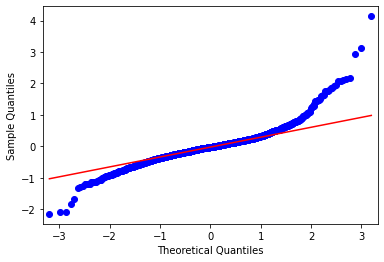

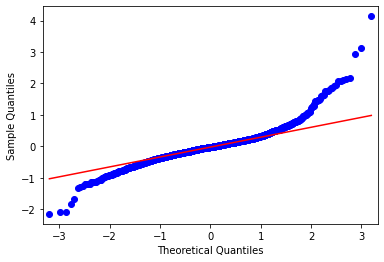

In [52]:
qqplot(lux_model1.resid, line = 'q')

## Luxury Model 2

power_price = minmax.fit_transform(np.array(log_price).reshape(-1, 1))
power_sqft_living = minmax.fit_transform(np.array(log_sqft_living).reshape(-1, 1))
power_sqft_lot = minmax.fit_transform(np.array(log_sqft_lot).reshape(-1, 1))
power_sqft_living15 = minmax.fit_transform(np.array(log_sqft_living15).reshape(-1, 1))
power_sqft_lot = minmax.fit_transform(np.array(log_sqft_lot15).reshape(-1, 1))

In [53]:
lux_ols2 = lux_ols_base[['price', 'sqft_living', 'waterfront', 'condition', 'sqft_lot15', 'unincorporated', 'location_cost', 'decade_built']]

lux_ols2 = lux_ols2.drop(columns = ['decade_built','waterfront', 'condition', 'unincorporated', 'location_cost'], axis = 1) ##dropping original categoricals
lux_ols2 = pd.concat([lux_ols2, built_dummies, water_dummies, cond_dummies, inc_dummies, loc_dummies], axis = 1)


lux_ols2['price'] = power_price
lux_ols2['sqft_living'] = power_sqft_living
lux_ols2['sqft_lot15'] = power_sqft_lot15


In [54]:
target = 'price'
x_cols = lux_ols2.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula2 = target + '~' + predictors

lux_model2 = ols(formula = formula2, data = lux_ols2).fit()
lux_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     210.5
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:26:38   Log-Likelihood:                -1024.4
No. Observations:                1440   AIC:                             2093.
Df Residuals:                    1418   BIC:                             2209.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3471      0.140     -9.637      0.000      -1.621      -1.073
sqft_living     0.4599      0.015     30.370      0.000       0.430       0.490
sqft_lot15      0.0739      0.017      4.254      0.000       0.040       0.108
built_1         0.0146      0.170      0.086      0.932      -0.319       0.348
built_2         0.0810      0.162      0.500      0.617      -0.237       0.399
built_3         0.2163      0.156      1.385      0.166      -0.090       0.523
built_4        -0.0474      0.200     -0.237      0.813      -0.440       0.345
built_5        -0.1676      0.156     -1.072      0.284      -0.474       0.139
built_6        -0.0568      0.149     -0.380      0.704      -0.350       0.236
built_7        -0.3475      0.140     -2.476      0.013      -0.623      -0.072
built_8        -0.2537      0.135     -1.878      0.061      -0.519       0.011
built_9        -0.1904      0.134     -1.421      0.155      -0.453       0.072
built_10       -0.1114      0.132     -0.842      0.400      -0.371       0.148
built_11        0.0144      0.137      0.105      0.916      -0.255       0.284
water_1         1.1359      0.070     16.323      0.000       0.999       1.272
cond_4          0.1240      0.043      2.894      0.004       0.040       0.208
cond_5          0.3147      0.072      4.384      0.000       0.174       0.455
city_1         -0.1825      0.042     -4.343      0.000      -0.265      -0.100
loc_2           1.2638      0.051     24.785      0.000       1.164       1.364
loc_3           1.8670      0.058     32.087      0.000       1.753       1.981
loc_4           2.3467      0.065     36.175      0.000       2.219       2.474
loc_5           2.6453      0.125     21.170      0.000       2.400       2.890
==============================================================================
Omnibus:                       68.932   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.475
Skew:                           0.085   Prob(JB):                     1.80e-49
Kurtosis:                       4.927   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

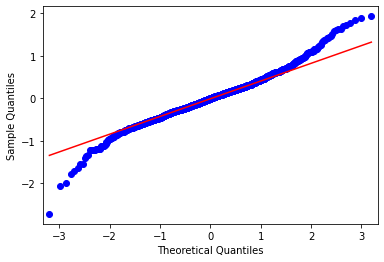

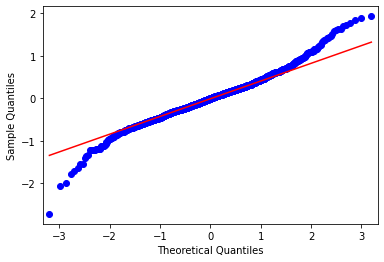

In [55]:
qqplot(lux_model2.resid, line = 'q')

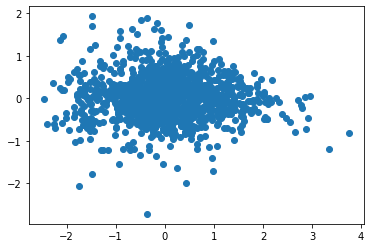

In [56]:
x = lux_model2.predict(lux_ols2.drop('price', axis = 1))
y = lux_model2.resid
plt.scatter(x, y);

In [57]:
lux_model2.resid.max()
x.max()

lux_ols2.loc[x[x == x.min()].index] ##the falsely-labeled home is one of the biggest outliers in this data set

#data.loc[y[y == y.max()].index]

,price,sqft_living,sqft_lot15,built_1,built_2,built_3,built_4,built_5,built_6,built_7,...,built_10,built_11,water_1,cond_4,cond_5,city_1,loc_2,loc_3,loc_4,loc_5
16083,-2.470365,-1.679808,0.484032,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Luxury Model 3

In [58]:
lux_ols3 = lux_ols_base[['price', 'waterfront', 'grade', 'sqft_living15', 'season_sold', 'unincorporated', 'location_cost']]


lux_ols3 = lux_ols3.drop(columns = ['waterfront', 'grade', 'season_sold', 'unincorporated', 'location_cost'], axis = 1) ##dropping original categoricals
lux_ols3 = pd.concat([lux_ols3, water_dummies, grade_dummies, season_dummies, inc_dummies, loc_dummies], axis = 1)

lux_ols3['price'] = power_price
lux_ols3['sqft_living15'] = power_sqft_living15

target = 'price'
x_cols = lux_ols3.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula3 = target + '~' + predictors

lux_model3 = ols(formula = formula3, data = lux_ols3).fit()
lux_model3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     227.3
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:26:39   Log-Likelihood:                -1235.2
No. Observations:                1440   AIC:                             2498.
Df Residuals:                    1426   BIC:                             2572.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.5796      0.063    -25.079      0.000      -1.703      -1.456
sqft_living15     0.1863      0.017     11.055      0.000       0.153       0.219
water_1           1.2597      0.079     15.861      0.000       1.104       1.416
grade_11          0.4575      0.037     12.236      0.000       0.384       0.531
grade_12          0.9914      0.070     14.249      0.000       0.855       1.128
grade_13          1.6433      0.163     10.069      0.000       1.323       1.963
month_spring      0.0859      0.043      2.009      0.045       0.002       0.170
month_summer     -0.0125      0.042     -0.294      0.768      -0.096       0.071
month_winter      0.0290      0.050      0.577      0.564      -0.069       0.127
city_1           -0.0335      0.045     -0.752      0.452      -0.121       0.054
loc_2             1.0531      0.059     17.951      0.000       0.938       1.168
loc_3             1.8561      0.065     28.490      0.000       1.728       1.984
loc_4             2.3836      0.070     33.902      0.000       2.246       2.522
loc_5             2.6441      0.145     18.246      0.000       2.360       2.928
==============================================================================
Omnibus:                       71.929   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.534
Skew:                          -0.012   Prob(JB):                     2.40e-55
Kurtosis:                       5.047   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

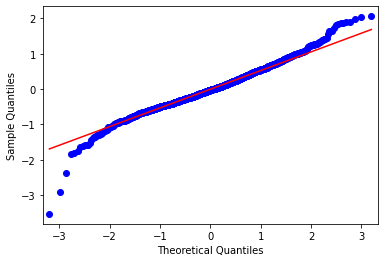

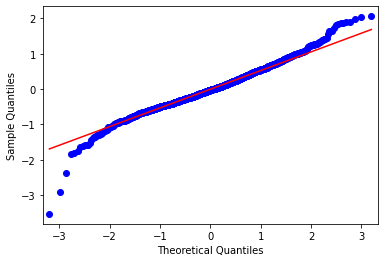

In [59]:
qqplot(lux_model3.resid, line = 'q')

## Luxury Model 4

In [60]:
lux_ols4 = lux_ols_base[['price', 'waterfront', 'grade', 'sqft_living15','location_cost']]


lux_ols4 = lux_ols4.drop(columns = ['waterfront', 'grade', 'location_cost'], axis = 1) ##dropping original categoricals
lux_ols4 = pd.concat([lux_ols4, water_dummies, grade_dummies, inc_dummies, loc_dummies], axis = 1)


scaled_lux_ols4 = pd.DataFrame(ss.fit_transform(lux_ols4))
scaled_lux_ols4.columns = lux_ols4.columns

scaled_lux_ols4['price'] = power_price
scaled_lux_ols4['sqft_living15'] = power_sqft_living15

scaled_lux_ols4

,price,sqft_living15,water_1,grade_11,grade_12,grade_13,city_1,loc_2,loc_3,loc_4,loc_5
0,0.298818,1.931177,-0.201153,1.761410,-0.245729,-0.095446,2.374014,0.851206,-0.506502,-0.380360,-0.115632
1,-0.076899,0.426588,-0.201153,1.761410,-0.245729,-0.095446,-0.421227,-1.174804,1.974325,-0.380360,-0.115632
2,-0.622690,0.056675,-0.201153,-0.567727,-0.245729,-0.095446,-0.421227,0.851206,-0.506502,-0.380360,-0.115632
3,0.051952,-0.891245,-0.201153,-0.567727,-0.245729,-0.095446,-0.421227,-1.174804,1.974325,-0.380360,-0.115632
4,-1.171191,-0.267490,-0.201153,-0.567727,-0.245729,-0.095446,2.374014,0.851206,-0.506502,-0.380360,-0.115632
...,...,...,...,...,...,...,...,...,...,...,...
1435,-0.776557,-1.203856,-0.201153,-0.567727,-0.245729,-0.095446,-0.421227,0.851206,-0.506502,-0.380360,-0.115632
1436,2.122253,0.350574,4.971346,-0.567727,-0.245729,-0.095446,-0.421227,-1.174804,1.974325,-0.380360,-0.115632
1437,0.281204,1.693001,-0.201153,1.761410,-0.245729,-0.095446,-0.421227,0.851206,-0.506502,-0.380360,-0.115632
1438,0.031200,-0.215282,-0.201153,-0.567727,-0.245729,-0.095446,-0.421227,0.851206,-0.506502,-0.380360,-0.115632


In [61]:
target = 'price'
x_cols = lux_ols4.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula4 = target + '~' + predictors

lux_model4 = ols(formula = formula4, data = lux_ols4).fit()
lux_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     299.3
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        18:26:39   Log-Likelihood:                -20662.
No. Observations:                1440   AIC:                         4.135e+04
Df Residuals:                    1429   BIC:                         4.140e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.515e+05   6.19e+04      2.447      0.015    3.01e+04    2.73e+05
sqft_living15   146.0880     15.719      9.294      0.000     115.253     176.923
water_1         1.32e+06   5.73e+04     23.022      0.000    1.21e+06    1.43e+06
grade_11       2.419e+05    2.7e+04      8.956      0.000    1.89e+05    2.95e+05
grade_12       8.088e+05   5.03e+04     16.086      0.000     7.1e+05    9.07e+05
grade_13       2.185e+06   1.18e+05     18.556      0.000    1.95e+06    2.42e+06
city_1        -1.553e+04   3.22e+04     -0.483      0.629   -7.86e+04    4.76e+04
loc_2          2.518e+05   4.24e+04      5.946      0.000    1.69e+05    3.35e+05
loc_3          7.246e+05    4.7e+04     15.411      0.000    6.32e+05    8.17e+05
loc_4          1.214e+06   5.07e+04     23.920      0.000    1.11e+06    1.31e+06
loc_5          1.832e+06   1.05e+05     17.524      0.000    1.63e+06    2.04e+06
==============================================================================
Omnibus:                      670.426   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8873.806
Skew:                           1.816   Prob(JB):                         0.00
Kurtosis:                      14.606   Cond. No.                     3.73e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Reigning In Price Outliers

In [62]:
priced_df = df[~(np.abs(stats.zscore(df['price_per_sqft'])) > 3)]

priced_df.shape

(21263, 29)

In [63]:
##Initializing dummies for this DataFrame

dummy_list = ['unincorporated','waterfront','bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'season_sold', 'location_cost', 'decade_built']

inc_dummies = pd.get_dummies(priced_df['unincorporated'].astype(int), prefix='city', drop_first=True)
bed_dummies = pd.get_dummies(priced_df['bedrooms'].astype(int), prefix='bed', drop_first=True)
bath_dummies = pd.get_dummies(priced_df['bathrooms'].astype(int), prefix = 'bath', drop_first = True)
floor_dummies = pd.get_dummies(priced_df['floors'].astype(int), prefix='floor', drop_first=True)
cond_dummies = pd.get_dummies(priced_df['condition'].astype(int), prefix='cond', drop_first=True)
grade_dummies = pd.get_dummies(priced_df['grade'].astype(int), prefix='grade', drop_first=True)
season_dummies = pd.get_dummies(priced_df['season_sold'], prefix='month', drop_first=True)
loc_dummies = pd.get_dummies(priced_df['location_cost'].astype(int), prefix='loc', drop_first=True)
built_dummies = pd.get_dummies(priced_df['decade_built'].astype(int), prefix='built', drop_first=True)

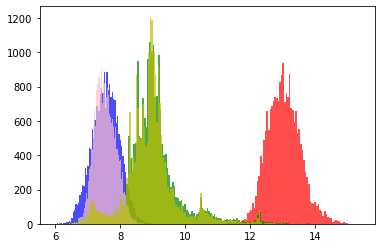

In [64]:
##Initialized log-transformed variables for all continuous variables without negative values

log_price = np.log(priced_df['price'])
log_sqft_living = np.log(priced_df['sqft_living'])
log_sqft_lot = np.log(priced_df['sqft_lot'])
log_sqft_living15 = np.log(priced_df['sqft_living15'])
log_sqft_lot15 = np.log(priced_df['sqft_lot15'])

plt.hist(log_price, bins = 'auto', color = 'r', alpha = .7);
plt.hist(log_sqft_living, bins = 'auto', color = 'b', alpha = .7);
plt.hist(log_sqft_lot, bins = 'auto', color = 'g', alpha = .7);
plt.hist(log_sqft_living15, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(log_sqft_lot15, bins = 'auto', color = 'y', alpha = .7);

21263

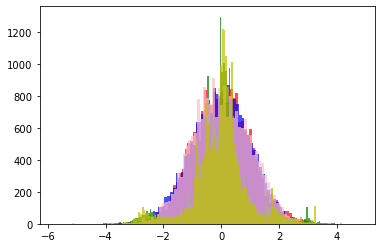

In [65]:
##Performed a Power Transformation on all continuous variable with no negative values

power = PowerTransformer()

power_price = power.fit_transform(np.array(log_price).reshape(-1, 1))
power_sqft_living = power.fit_transform(np.array(log_sqft_living).reshape(-1, 1))
power_sqft_lot = power.fit_transform(np.array(log_sqft_lot).reshape(-1, 1))
power_sqft_living15 = power.fit_transform(np.array(log_sqft_living15).reshape(-1, 1))
power_sqft_lot15 = power.fit_transform(np.array(log_sqft_lot15).reshape(-1, 1))

plt.hist(power_price, bins = 'auto', color = 'r', alpha = .7);
plt.hist(power_sqft_living, bins = 'auto', color = 'b', alpha = .7);
plt.hist(power_sqft_lot, bins = 'auto', color = 'g', alpha = .7);
plt.hist(power_sqft_living15, bins = 'auto', color = 'pink', alpha = .7);
plt.hist(power_sqft_lot15, bins = 'auto', color = 'y', alpha = .7);

len(power_price)

In [66]:
priced_ols1 = priced_df[['price', 'grade', 'sqft_living15', 'season_sold', 'unincorporated', 'location_cost']]


priced_ols1 = priced_ols1.drop(columns = ['grade', 'season_sold', 'unincorporated', 'location_cost'], axis = 1) ##dropping original categoricals
priced_ols1 = pd.concat([priced_ols1, water_dummies, grade_dummies, season_dummies, inc_dummies, loc_dummies], axis = 1)

priced_ols1['price'] = power_price
priced_ols1['sqft_living15'] = power_sqft_living15

target = 'price'
x_cols = priced_ols1.drop('price', axis = 1).columns
predictors = '+'.join(x_cols)

formula5 = target + '~' + predictors

priced_model1 = ols(formula = formula5, data = lux_ols3).fit()
priced_model1.summary()


<ipython-input-66-f83db4eb7668>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priced_ols1.dropna(inplace = True)


ValueError: Length of values (21263) does not match length of index (21339)